
# NFL Player Obscurity Score Calculator 🏈

This notebook computes *obscurity scores* for NFL players using a combination of heuristics and deep learning.


In [3]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TF warnings


2025-03-27 13:19:17.052469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743095957.068623    2416 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743095957.074554    2416 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 13:19:17.140318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def compute_obscurity_scores(csv_file, output_file=None):
    """
    Compute obscurity scores for NFL players using deep learning.

    This function:
    1. Loads NFL player data
    2. Processes and normalizes relevant features
    3. Creates a custom deep learning model
    4. Computes obscurity scores (100 = most obscure, 0 = least obscure)
    5. Returns dataframe with added obscurity scores

    Args:
        csv_file (str): Path to CSV file with NFL player data
        output_file (str, optional): Path to save results. If None, doesn't save.

    Returns:
        pandas.DataFrame: Player data with computed obscurity scores
    """
    # 1. Load and prepare the data
    df = pd.read_csv(csv_file)

    # Clean the data
    df = df.fillna(0)

    # 2. Feature extraction & engineering

    # A. Basic visibility features
    # Pageviews - direct measure of visibility (inverse relation to obscurity)
    if 'Pageviews' in df.columns:
        df['pageviews_factor'] = df['Pageviews']
    else:
        # If no pageviews data, estimate from games played and awards
        df['pageviews_factor'] = df['G'] * 5000

    # B. Accomplishment features
    # Combine awards
    df['awards_count'] = df['MVP'] + df['OPOY'] + df['DPOY'] + \
        df['OROY'] + df['DROY'] + df['AP1'] + df['SB']

    # C. Position-specific performance metrics
    # For QBs
    df['qb_career_value'] = 0
    qb_mask = df['Pos'] == 'QB'
    if qb_mask.any():
        df.loc[qb_mask, 'qb_career_value'] = (
            df.loc[qb_mask, 'PaYds'] * 0.1 +
            df.loc[qb_mask, 'PaTD'] * 5 +
            df.loc[qb_mask, 'QBWin'] * 10 +
            df.loc[qb_mask, 'GWD'] * 15
        )

    # For RBs
    df['rb_career_value'] = 0
    rb_mask = df['Pos'] == 'RB'
    if rb_mask.any():
        df.loc[rb_mask, 'rb_career_value'] = (
            df.loc[rb_mask, 'RuYds'] * 0.2 +
            df.loc[rb_mask, 'RuTD'] * 10 +
            df.loc[rb_mask, 'RecYds'] * 0.15
        )

    # For WRs/TEs
    df['wr_te_career_value'] = 0
    wr_te_mask = (df['Pos'] == 'WR') | (df['Pos'] == 'TE')
    if wr_te_mask.any():
        df.loc[wr_te_mask, 'wr_te_career_value'] = (
            df.loc[wr_te_mask, 'RecYds'] * 0.2 +
            df.loc[wr_te_mask, 'RecTD'] * 10 +
            df.loc[wr_te_mask, 'Rec'] * 0.5
        )

    # For defensive players
    df['def_career_value'] = 0
    def_mask = df['Pos'].isin(['DE', 'DT', 'LB', 'CB', 'S'])
    if def_mask.any():
        df.loc[def_mask, 'def_career_value'] = (
            df.loc[def_mask, 'Solo'] * 1 +
            df.loc[def_mask, 'Ast'] * 0.5 +
            df.loc[def_mask, 'TFL'] * 3 +
            df.loc[def_mask, 'IntD'] * 15 +
            df.loc[def_mask, 'FF'] * 10
        )

    # Combine all position values into a single career value metric
    career_value_cols = ['qb_career_value', 'rb_career_value',
                         'wr_te_career_value', 'def_career_value']
    df['career_value'] = df[career_value_cols].max(axis=1)

    # D. Career longevity and volume
    df['games_factor'] = df['G'] / df['G'].max() if df['G'].max() > 0 else 0
    df['fantasy_factor'] = df['FantPts'] / \
        df['FantPts'].max() if df['FantPts'].max() > 0 else 0

    # 3. Calculate the base obscurity score using key metrics

    # A. Extract normalized key metrics (higher = less obscure)
    # Reverse the logic: higher values in these metrics = lower obscurity
    metrics = pd.DataFrame()

    # Normalize each metric to 0-1 range
    if df['pageviews_factor'].max() > 0:
        metrics['pageviews'] = df['pageviews_factor'] / \
            df['pageviews_factor'].max()
    else:
        metrics['pageviews'] = 0

    # Normalizing assuming 10 awards is maximum
    metrics['awards'] = df['awards_count'] / 10
    metrics['career_value'] = df['career_value'] / \
        df['career_value'].max() if df['career_value'].max() > 0 else 0
    metrics['games'] = df['games_factor']
    metrics['fantasy'] = df['fantasy_factor']

    # B. Calculate the visibility score (inverse of obscurity)
    # Weight the metrics based on importance
    weights = {
        'pageviews': 0.65,
        'awards': 0.1,
        'career_value': 0.225,
        'games': 0.025,
        'fantasy': 0.00
    }

    visibility_score = (
        metrics['pageviews'] * weights['pageviews'] +
        metrics['awards'] * weights['awards'] +
        metrics['career_value'] * weights['career_value'] +
        metrics['games'] * weights['games'] +
        metrics['fantasy'] * weights['fantasy']
    )

    # C. Convert visibility to obscurity (100 = most obscure, 0 = least obscure)
    df['obscurity_score_basic'] = 100 * (1 - visibility_score)

    # 4. Deep Learning Enhancement
    # Use a neural network to capture more complex relationships

    # A. Prepare features for deep learning
    feature_cols = [
        'pageviews_factor', 'awards_count', 'career_value',
        'G', 'GS', 'FantPts'
    ]

    categorical_cols = ['Pos']

    # Create position-specific performance columns for better feature representation
    for pos in df['Pos'].unique():
        # Skip if position is missing/nan
        if pd.isna(pos):
            continue

        pos_mask = df['Pos'] == pos
        if pos_mask.sum() > 0:
            # For each position, add relevant stat columns
            if pos == 'QB':
                df[f'{pos}_PaYds_per_G'] = df['PaYds'] / \
                    df['G'].where(df['G'] > 0, 1)
                df[f'{pos}_PaTD_per_G'] = df['PaTD'] / \
                    df['G'].where(df['G'] > 0, 1)
                feature_cols.extend(
                    [f'{pos}_PaYds_per_G', f'{pos}_PaTD_per_G'])
            elif pos == 'RB':
                df[f'{pos}_RuYds_per_G'] = df['RuYds'] / \
                    df['G'].where(df['G'] > 0, 1)
                df[f'{pos}_RuTD_per_G'] = df['RuTD'] / \
                    df['G'].where(df['G'] > 0, 1)
                feature_cols.extend(
                    [f'{pos}_RuYds_per_G', f'{pos}_RuTD_per_G'])
            elif pos in ['WR', 'TE']:
                df[f'{pos}_RecYds_per_G'] = df['RecYds'] / \
                    df['G'].where(df['G'] > 0, 1)
                df[f'{pos}_RecTD_per_G'] = df['RecTD'] / \
                    df['G'].where(df['G'] > 0, 1)
                feature_cols.extend(
                    [f'{pos}_RecYds_per_G', f'{pos}_RecTD_per_G'])

    # Fill any NaNs created during the calculation
    df = df.fillna(0)

    # Select features and preprocess
    X = df[feature_cols + categorical_cols]

    # Create preprocessing pipeline with sparse output for categorical features
    numerical_transformer = StandardScaler()

    # Use sparse output for OneHotEncoder to save memory
    categorical_transformer = OneHotEncoder(
        handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, feature_cols),
            ('cat', categorical_transformer, categorical_cols)
        ],
        sparse_threshold=0  # Force dense output from the transformer
    )

    # Fit and transform the data
    X_processed = preprocessor.fit_transform(X)

    # B. Build and train the model
    # We'll use the basic obscurity score as a starting point
    # and refine it with the neural network
    initial_obscurity = df['obscurity_score_basic'].values

    # Define the model with memory optimization
    model = keras.Sequential([
        layers.InputLayer(input_shape=(X_processed.shape[1],)),
        layers.Dense(32, activation='relu', use_bias=True),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', use_bias=True),
        layers.Dense(1, activation='sigmoid')  # Output between 0 and 1
    ])

    # Use a memory-efficient optimizer
    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    # Train the model to learn from the initial obscurity scores
    # This helps capture complex non-linear relationships

    # Set up callbacks to handle warnings
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=5,
            restore_best_weights=True
        )
    ]

    # Suppress TensorFlow warnings during training
    import os
    import tensorflow as tf
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TF warnings

    # Train with memory-optimized settings
    model.fit(
        X_processed,
        initial_obscurity / 100,  # Scale to 0-1 for training
        epochs=30,  # Reduced epochs
        batch_size=8,  # Increased batch size for better memory efficiency
        callbacks=callbacks,
        verbose=1
    )

    # Make predictions and convert back to 0-100 scale
    refined_obscurity = model.predict(X_processed).flatten() * 100

    # Combine initial and refined scores (giving more weight to refined)
    df['obscurity_score'] = 0.3 * \
        df['obscurity_score_basic'] + 0.7 * refined_obscurity
    
    # Custom adjustments based on position
    position_adjustments = {
        'QB': 0.85,  # Reduce obscurity by 15% (more visible)
        'RB': 1.0,   # No change
        'WR': 0.95,  # Reduce obscurity by 5%
        'TE': 1.05,  # Slightly increase (less visible)
        'DE': 1.1,   # More obscure
        'DT': 1.15,
        'LB': 1.05,
        'CB': 1.0,
        'S': 1.1,
        # Add more positions as needed
    }

    df['obscurity_score'] = df.apply(
        lambda row: row['obscurity_score'] * position_adjustments.get(row['Pos'], 1.0),
        axis=1
    )

    # 5. Apply business rules and adjustments

    # A. Award winners should have lower obscurity
    # Super Bowl winners, MVPs, etc. are well-known
    award_winners = df['awards_count'] > 0
    if award_winners.any():
        df.loc[award_winners, 'obscurity_score'] *= 0.8  # Reduce obscurity by 20%

    # B. Long careers lead to more visibility
    long_careers = df['G'] > 100
    if long_careers.any():
        df.loc[long_careers, 'obscurity_score'] *= 0.9  # Reduce obscurity by 10%

    # C. Recent Rookie of the Year winners get more attention
    rookies = (df['OROY'] > 0) | (df['DROY'] > 0)
    if rookies.any():
        df.loc[rookies, 'obscurity_score'] *= 0.85  # Reduce obscurity by 15%

    # D. Clean up final scores
    # Ensure scores are within 0-100 range
    df['obscurity_score'] = df['obscurity_score'].clip(0, 100)

    # E. Transform the distribution to be more normal
    # First, calculate mean and standard deviation of current scores
    mean_score = df['obscurity_score'].mean()
    std_score = df['obscurity_score'].std()

    # If standard deviation is too small, set a minimum value
    std_score = max(std_score, 10)

    # Apply transformation to create more of a normal distribution
    # This uses a logistic function to spread out the values
    from scipy import stats

    # Convert to z-scores first
    z_scores = (df['obscurity_score'] - mean_score) / std_score

    # Apply sigmoid transformation to spread values more evenly
    transformed_scores = 1 / (1 + np.exp(-z_scores))

    # Scale back to 0-100 range with better spread
    # Adjust these parameters to control the shape of the distribution
    min_target = 5    # Minimum obscurity score
    max_target = 95   # Maximum obscurity score
    range_target = max_target - min_target

    df['obscurity_score_normalized'] = min_target + \
        range_target * transformed_scores

    # Apply a second transformation to improve normality
    # Use percentile rank method to create a more uniform distribution first
    percentile_ranks = df['obscurity_score_normalized'].rank(pct=True)

    # Then transform to normal distribution using inverse normal CDF
    from scipy.stats import norm
    df['obscurity_score'] = norm.ppf(percentile_ranks) * 15 + 50

    # Clip values to ensure they stay in 0-100 range
    df['obscurity_score'] = df['obscurity_score'].clip(0, 100)

    # Round to 2 decimal places
    df['obscurity_score'] = df['obscurity_score'].round(2)

    # 6. Create a scaled version (0-100 scale to 0-50 scale)
    df['obscurity_score_scaled'] = (df['obscurity_score'] * 0.5).round(2)

    # 7. Save the results if output file provided
    if output_file:
        # Select relevant columns for output
        output_df = df.copy()

        # Drop intermediate calculation columns
        cols_to_drop = [
            'pageviews_factor', 'awards_count', 'qb_career_value',
            'rb_career_value', 'wr_te_career_value', 'def_career_value',
            'career_value', 'games_factor', 'fantasy_factor',
            'obscurity_score_basic'
        ]

        # Also drop position-specific columns we created
        pos_cols = [col for col in output_df.columns if any(
            f'{pos}_' in col for pos in df['Pos'].unique())]
        cols_to_drop.extend(pos_cols)

        # Drop columns that exist
        cols_to_drop = [
            col for col in cols_to_drop if col in output_df.columns]
        output_df = output_df.drop(columns=cols_to_drop)

        # Save to CSV
        output_df.sort_values('obscurity_score', ascending=False).to_csv(output_file, index=False)

    # 8. Return the dataframe with obscurity scores
    return df
    

In [5]:

# Path to your NFL player data (update as needed)
input_file = "nfl_locked.csv"
# input_file = "nfl_locked.csv"
output_file = "nfl_players_with_obscurity.csv"

# Compute obscurity scores
result_df = compute_obscurity_scores(input_file, output_file)
result_df.head()


/tmp/ipykernel_2416/191811782.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.07980e+03 7.00000e+00 7.03290e+03 1.02500e+02 3.71590e+03 0.00000e+00
 3.19700e+02 4.69340e+03 2.07150e+03 3.04700e+02 6.49000e+03 8.08000e+02
 1.22000e+02 5.19100e+02 3.23600e+02 3.11510e+03 1.18000e+02 2.94040e+03
 3.77750e+03 3.37300e+02 2.28000e+01 5.31370e+03 1.51300e+02 5.81300e+02
 6.67500e+02 1.92200e+02 2.60000e+01 5.72580e+03 6.20000e+00 2.32200e+03
 3.70000e+00 1.37040e+03 1.50000e+02 8.86700e+02 1.26350e+03 2.37750e+03
 4.19100e+02 7.23000e+01 7.32470e+03 2.05150e+03 8.76000e+01 5.13600e+02
 1.57400e+03 5.69520e+03 0.00000e+00 3.67100e+03 1.81000e+03 5.83000e+02
 6.35200e+02 3.44430e+03 1.06630e+03 1.28300e+02 2.68780e+03 9.68090e+03
 2.58060e+03 4.28600e+02 1.50000e+02 2.62830e+03 2.18320e+03 9.07900e+02
 3.32600e+02 2.91000e+01 1.68500e+03 6.70450e+03 2.19000e+01 2.76000e+01
 1.51700e+02 2.35800e+02 1.4600

Epoch 1/30


I0000 00:00:1743095963.281141    6348 service.cc:148] XLA service 0x7f3bc800c560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743095963.281174    6348 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-27 13:19:23.321007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743095963.449466    6348 cuda_dnn.cc:529] Loaded cuDNN version 90800


 28/274 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3237 - mae: 0.5255

I0000 00:00:1743095964.479890    6348 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


261/274 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1832 - mae: 0.3577

E0000 00:00:1743095966.199624    6348 buffer_comparator.cc:157] Difference at 1024: -nan, expected 4.5983
E0000 00:00:1743095966.199663    6348 buffer_comparator.cc:157] Difference at 1025: -nan, expected 3.12297
E0000 00:00:1743095966.199668    6348 buffer_comparator.cc:157] Difference at 1026: -nan, expected 2.5009
E0000 00:00:1743095966.199671    6348 buffer_comparator.cc:157] Difference at 1027: -nan, expected 3.43792
E0000 00:00:1743095966.199673    6348 buffer_comparator.cc:157] Difference at 1028: -nan, expected 2.75373
E0000 00:00:1743095966.199675    6348 buffer_comparator.cc:157] Difference at 1029: -nan, expected 2.89655
E0000 00:00:1743095966.199676    6348 buffer_comparator.cc:157] Difference at 1030: -nan, expected 3.12067
E0000 00:00:1743095966.199678    6348 buffer_comparator.cc:157] Difference at 1031: -nan, expected 3.83844
E0000 00:00:1743095966.199680    6348 buffer_comparator.cc:157] Difference at 1032: -nan, expected 3.04959
E0000 00:00:1743095966.199682    6348 b

274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.1785 - mae: 0.3509
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - mae: 0.0566
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0036 - mae: 0.0318
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0019 - mae: 0.0235
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ -1s -4453us/step - loss: 0.0022 - mae: 0.0211
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0021 - mae: 0.0193
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - mae: 0.0171
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0017 - mae: 0.0162
Epoch 9/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013 - mae: 0.0166
Epoch 10/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - mae: 0.0160
Epoch 11/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - mae: 0.0141  
Epoch 12/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010 - mae: 0.0150
Epoch 13/30
274/274 ━━━━━━━━

,Unnamed: 0,Team,Pageviews,G,GS,Cmp,PaAtt,Cmp%,PaYds,PaTD,...,QB_PaTD_per_G,RB_RuYds_per_G,RB_RuTD_per_G,WR_RecYds_per_G,WR_RecTD_per_G,TE_RecYds_per_G,TE_RecTD_per_G,obscurity_score,obscurity_score_normalized,obscurity_score_scaled
0,0,Arizona Cardinals,845475.0,82,82,1864,2780,67.1,19498,115,...,1.402439,36.829268,0.378049,0.085366,0.000000,0.085366,0.000000,14.31,6.500135,7.16
1,1,Arizona Cardinals,56850.0,13,1,14,23,60.9,70,0,...,0.000000,2.000000,0.076923,0.000000,0.000000,0.000000,0.000000,34.73,30.369003,17.36
2,2,Arizona Cardinals,110208.0,13,1,0,0,0.0,0,0,...,0.000000,22.384615,0.076923,4.538462,0.000000,4.538462,0.000000,50.52,61.734091,25.26
3,3,Arizona Cardinals,50197.0,48,22,0,0,0.0,0,0,...,0.000000,28.312500,0.166667,16.062500,0.020833,16.062500,0.020833,46.08,60.226105,23.04
4,4,Arizona Cardinals,198361.0,107,81,0,0,0.0,0,0,...,0.000000,55.794393,0.551402,20.719626,0.102804,20.719626,0.102804,35.54,36.574211,17.77


In [6]:

print("Top 5 Most Obscure Players:")
most_obscure = result_df.sort_values('obscurity_score', ascending=False).head(10)
print(most_obscure[['Player', 'Pos', 'Team', 'G', 'obscurity_score', 'obscurity_score_scaled']])

print("\nTop 5 Least Obscure Players:")
least_obscure = result_df.sort_values('obscurity_score').head(10)
print(least_obscure[['Player', 'Pos', 'Team', 'G', 'obscurity_score', 'obscurity_score_scaled']])

print("\nMid Obscure Players (around rank 800-850):")
mid_obscure = result_df.sort_values('obscurity_score')
mid_obscure = mid_obscure[800:850]
print(mid_obscure[['Player', 'Pos', 'Team', 'G', 'obscurity_score', 'obscurity_score_scaled']])


Top 5 Most Obscure Players:
                 Player Pos                   Team   G  obscurity_score  \
14       Elijah Higgins  TE      Arizona Cardinals  28            67.28   
2187       Mykal Walker  LB  Washington Commanders  74            67.28   
15         Trey McBride  TE      Arizona Cardinals  49            67.28   
16           Tip Reiman  TE      Arizona Cardinals  17            67.28   
1433      Jack Westover  TE   New England Patriots   3            67.28   
1447  Christian Barmore  DT   New England Patriots  48            67.28   
56          Krys Barnes  LB      Arizona Cardinals  68            67.28   
27         PJ Mustipher  DT      Arizona Cardinals   4            67.28   
34          Milo Eifler  LB      Arizona Cardinals  17            67.28   
35             Vi Jones  LB      Arizona Cardinals  10            67.28   

      obscurity_score_scaled  
14                     33.64  
2187                   33.64  
15                     33.64  
16                    

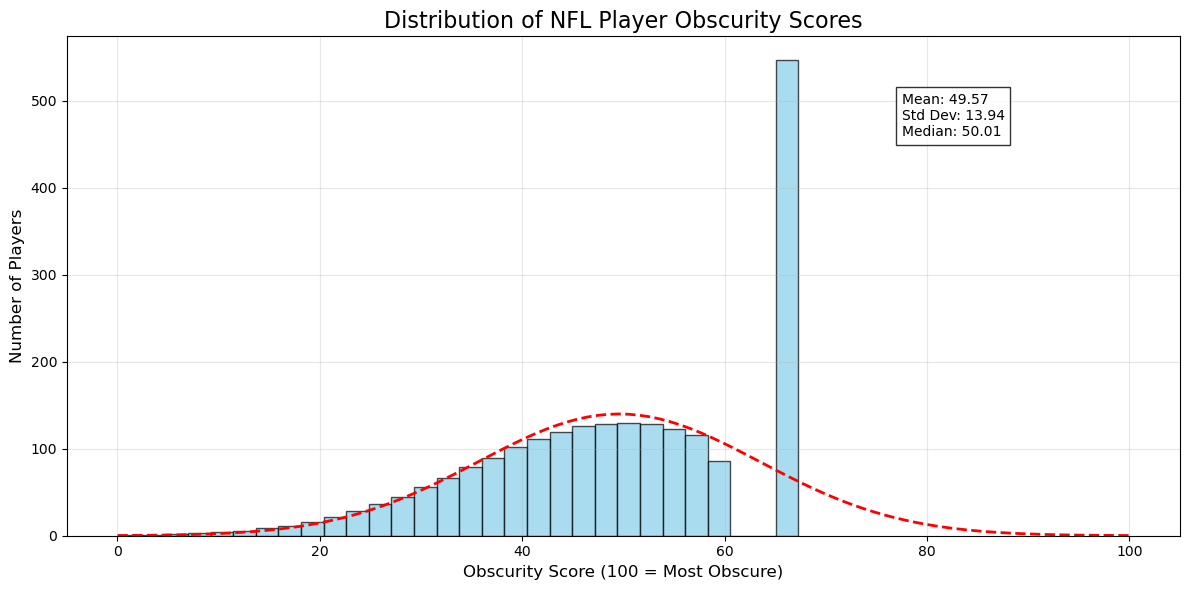

In [7]:

plt.figure(figsize=(12, 6))
n, bins, patches = plt.hist(result_df['obscurity_score'], bins=30,
                            color='skyblue', edgecolor='black', alpha=0.7)

mu = result_df['obscurity_score'].mean()
sigma = result_df['obscurity_score'].std()
x = np.linspace(0, 100, 100)
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 *
     ((x - mu) / sigma) ** 2)) * len(result_df) * (bins[1] - bins[0])
plt.plot(x, y, 'r--', linewidth=2)

plt.title('Distribution of NFL Player Obscurity Scores', fontsize=16)
plt.xlabel('Obscurity Score (100 = Most Obscure)', fontsize=12)
plt.ylabel('Number of Players', fontsize=12)
plt.grid(alpha=0.3)

stats_text = f"Mean: {mu:.2f}\nStd Dev: {sigma:.2f}\nMedian: {result_df['obscurity_score'].median():.2f}"
plt.text(0.75, 0.8, stats_text, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()
